In [1]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download spandan2/cats-faces-64x64-for-generative-models
!unzip cats-faces-64x64-for-generative-models.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import datasets, models
import torchvision.transforms as tt
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
import os
from torchvision.utils import save_image
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import tensorflow as tf
tf.config.list_physical_devices('GPU')

cuda


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
batch_size = 128
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
data_dir = '/content/cats'
dataset = datasets.ImageFolder(data_dir, transform=tt.Compose([tt.Resize(image_size), tt.CenterCrop(image_size), tt.ToTensor(),tt.Normalize(*stats)]))

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


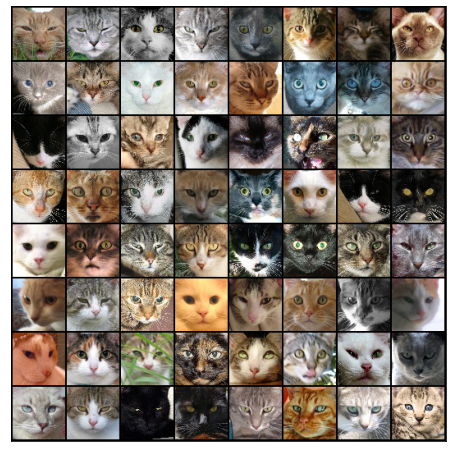

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(data_loader)

In [7]:
discriminator = nn.Sequential(
    #3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [8]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generator.to(device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [13]:
def training_discriminator(data, optimizerD):
    optimizerD.zero_grad()
    
    real_predictions = discriminator(data)
    real_targets = torch.rand(data.size(0), 1, device=device) * (0.1 - 0) + 0 
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) 
    real_score = torch.mean(real_predictions).item() 
    
  
    latent_batch = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fakeimage = generator(latent_batch)
    

    gen_predictions = discriminator(fakeimage)

    gen_targets = torch.rand(fakeimage.size(0), 1, device=device) * (1 - 0.9) + 0.9 
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() 
    
    total_loss = real_loss + gen_loss
    total_loss.backward()
    optimizerD.step()

    return total_loss.item(), real_score, gen_score

In [14]:
def training_generator(optimizerG):
    optimizerG.zero_grad()
    
    latent_batch = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fakeimage = generator(latent_batch)

    disc_predictions = discriminator(fakeimage)
    targets = torch.zeros(fakeimage.size(0), 1, device=device) 
    loss = F.binary_cross_entropy(disc_predictions, targets) 
    
    loss.backward()
    optimizerG.step()

    return loss.item()

In [11]:
ujmappa = 'generated'
os.makedirs(ujmappa, exist_ok=True)

def save_results(index, latent_batch, show=True):

    generated_image = generator(latent_batch)
    file = "{0:0=4d}.png".format(index)
    save_image(denorm(generated_image), os.path.join(ujmappa, file), nrow=8)
    
    if show:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(generated_image.cpu().detach(), nrow=8).permute(1, 2, 0))

In [15]:
f_latent = torch.randn(64, latent_size, 1, 1, device=device)
lr = 0.0002
epochs = 60

def final_training(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    lossesD = []
    scoresD = []

    lossesG = []
    scoresG = []
    
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
    
    for epoch in range(epochs):

        for sourceimages, _ in tqdm(data_loader):
            sourceimages = sourceimages.to(device)

            disc_loss, real_score, gen_score = training_discriminator(sourceimages, optimizerD)
            gen_loss = training_generator(optimizerG)
        
        lossesD.append(disc_loss)
        scoresD.append(real_score)
        lossesG.append(gen_loss)
        scoresG.append(gen_score)
        
        print("Epoch [{}/{}], generátor veszteség: {:.4f}, diszkriminátor veszteség: {:.4f},\n valós score: {:.4f}, generátor score: {:.4f}"
        .format(epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        save_results(epoch + start_idx, f_latent, show=False)
    
    return lossesD, scoresD, lossesG, scoresG

In [17]:
letsgooo = final_training(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/60], generátor veszteség: 3.6564, diszkriminátor veszteség: 0.8866,
 valós score: 0.2101, generátor score: 0.6215


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], generátor veszteség: 2.9679, diszkriminátor veszteség: 0.6764,
 valós score: 0.3101, generátor score: 0.9208


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], generátor veszteség: 3.3696, diszkriminátor veszteség: 0.6440,
 valós score: 0.2321, generátor score: 0.8942


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], generátor veszteség: 4.1629, diszkriminátor veszteség: 0.8665,
 valós score: 0.1569, generátor score: 0.5891


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], generátor veszteség: 4.9505, diszkriminátor veszteség: 0.4412,
 valós score: 0.0458, generátor score: 0.9097


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], generátor veszteség: 5.9718, diszkriminátor veszteség: 1.5308,
 valós score: 0.0314, generátor score: 0.3063


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], generátor veszteség: 4.1757, diszkriminátor veszteség: 0.6067,
 valós score: 0.1570, generátor score: 0.9007


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], generátor veszteség: 5.1499, diszkriminátor veszteség: 0.6657,
 valós score: 0.0862, generátor score: 0.7214


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], generátor veszteség: 6.2445, diszkriminátor veszteség: 1.5079,
 valós score: 0.0430, generátor score: 0.2972


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], generátor veszteség: 2.6101, diszkriminátor veszteség: 0.5750,
 valós score: 0.1433, generátor score: 0.7557


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], generátor veszteség: 1.3651, diszkriminátor veszteség: 1.2278,
 valós score: 0.5822, generátor score: 0.8524


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], generátor veszteség: 2.0479, diszkriminátor veszteség: 0.8215,
 valós score: 0.4226, generátor score: 0.9057


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], generátor veszteség: 0.7061, diszkriminátor veszteség: 1.2752,
 valós score: 0.5809, generátor score: 0.8570


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], generátor veszteség: 2.9691, diszkriminátor veszteség: 0.5458,
 valós score: 0.2066, generátor score: 0.8734


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], generátor veszteség: 3.4925, diszkriminátor veszteség: 0.5286,
 valós score: 0.0973, generátor score: 0.7545


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], generátor veszteség: 0.6176, diszkriminátor veszteség: 1.3038,
 valós score: 0.6733, generátor score: 0.9372


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], generátor veszteség: 4.2501, diszkriminátor veszteség: 0.5523,
 valós score: 0.2172, generátor score: 0.9621


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], generátor veszteség: 3.2279, diszkriminátor veszteség: 0.4993,
 valós score: 0.1966, generátor score: 0.9495


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], generátor veszteség: 6.3346, diszkriminátor veszteség: 0.9570,
 valós score: 0.0641, generátor score: 0.5198


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], generátor veszteség: 1.6102, diszkriminátor veszteség: 1.0719,
 valós score: 0.5512, generátor score: 0.9181


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], generátor veszteség: 1.6137, diszkriminátor veszteség: 2.4790,
 valós score: 0.9073, generátor score: 0.9337


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], generátor veszteség: 1.8842, diszkriminátor veszteség: 1.4383,
 valós score: 0.7103, generátor score: 0.9695


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], generátor veszteség: 1.9278, diszkriminátor veszteség: 1.0508,
 valós score: 0.5194, generátor score: 0.9390


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], generátor veszteség: 1.4198, diszkriminátor veszteség: 1.8378,
 valós score: 0.7297, generátor score: 0.9625


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], generátor veszteség: 2.5970, diszkriminátor veszteség: 0.5615,
 valós score: 0.1209, generátor score: 0.8008


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], generátor veszteség: 2.7692, diszkriminátor veszteség: 0.9587,
 valós score: 0.4693, generátor score: 0.9787


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], generátor veszteség: 4.5628, diszkriminátor veszteség: 0.6384,
 valós score: 0.0171, generátor score: 0.7655


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], generátor veszteség: 1.0417, diszkriminátor veszteség: 0.6603,
 valós score: 0.3160, generátor score: 0.9280


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], generátor veszteség: 2.9397, diszkriminátor veszteség: 1.2145,
 valós score: 0.6039, generátor score: 0.9851


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], generátor veszteség: 1.2355, diszkriminátor veszteség: 1.0621,
 valós score: 0.5400, generátor score: 0.9638


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], generátor veszteség: 2.0184, diszkriminátor veszteség: 0.5408,
 valós score: 0.1535, generátor score: 0.8838


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], generátor veszteség: 4.5635, diszkriminátor veszteség: 0.5777,
 valós score: 0.0360, generátor score: 0.8021


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], generátor veszteség: 2.8622, diszkriminátor veszteség: 2.4408,
 valós score: 0.8666, generátor score: 0.9955


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], generátor veszteség: 2.6953, diszkriminátor veszteség: 0.4635,
 valós score: 0.0850, generátor score: 0.8938


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], generátor veszteség: 6.2665, diszkriminátor veszteség: 0.9354,
 valós score: 0.4205, generátor score: 0.9988


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], generátor veszteség: 0.5902, diszkriminátor veszteség: 2.2868,
 valós score: 0.8405, generátor score: 0.8668


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], generátor veszteség: 2.7102, diszkriminátor veszteség: 0.4828,
 valós score: 0.1240, generátor score: 0.9338


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], generátor veszteség: 3.3840, diszkriminátor veszteség: 0.5241,
 valós score: 0.0631, generátor score: 0.9153


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], generátor veszteség: 1.7366, diszkriminátor veszteség: 0.6431,
 valós score: 0.2971, generátor score: 0.9246


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], generátor veszteség: 0.8822, diszkriminátor veszteség: 0.9229,
 valós score: 0.4709, generátor score: 0.8371


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], generátor veszteség: 2.7143, diszkriminátor veszteség: 0.3636,
 valós score: 0.0357, generátor score: 0.9193


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], generátor veszteség: 3.2129, diszkriminátor veszteség: 0.4696,
 valós score: 0.1105, generátor score: 0.9339


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], generátor veszteség: 1.0279, diszkriminátor veszteség: 0.7697,
 valós score: 0.3201, generátor score: 0.8663


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], generátor veszteség: 1.8655, diszkriminátor veszteség: 0.5429,
 valós score: 0.1901, generátor score: 0.9732


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], generátor veszteség: 2.6960, diszkriminátor veszteség: 0.5479,
 valós score: 0.2275, generátor score: 0.9689


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], generátor veszteség: 1.9116, diszkriminátor veszteség: 0.7079,
 valós score: 0.3694, generátor score: 0.9421


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], generátor veszteség: 3.6121, diszkriminátor veszteség: 0.4823,
 valós score: 0.0818, generátor score: 0.9730


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], generátor veszteség: 2.4823, diszkriminátor veszteség: 0.7368,
 valós score: 0.2990, generátor score: 0.9848


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], generátor veszteség: 1.0387, diszkriminátor veszteség: 1.9965,
 valós score: 0.8220, generátor score: 0.8879


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], generátor veszteség: 2.4083, diszkriminátor veszteség: 0.4557,
 valós score: 0.1202, generátor score: 0.8905


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], generátor veszteség: 5.0199, diszkriminátor veszteség: 0.6841,
 valós score: 0.0689, generátor score: 0.7161


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], generátor veszteség: 4.5220, diszkriminátor veszteség: 0.7313,
 valós score: 0.0461, generátor score: 0.6877


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/60], generátor veszteség: 1.5755, diszkriminátor veszteség: 0.5433,
 valós score: 0.2445, generátor score: 0.9496


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/60], generátor veszteség: 4.4898, diszkriminátor veszteség: 0.8917,
 valós score: 0.4197, generátor score: 0.9970


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/60], generátor veszteség: 1.4545, diszkriminátor veszteség: 1.4840,
 valós score: 0.7253, generátor score: 0.9612


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/60], generátor veszteség: 2.1462, diszkriminátor veszteség: 0.4835,
 valós score: 0.1488, generátor score: 0.8508


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/60], generátor veszteség: 0.8356, diszkriminátor veszteség: 1.5186,
 valós score: 0.7387, generátor score: 0.9808


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/60], generátor veszteség: 4.6658, diszkriminátor veszteség: 1.9253,
 valós score: 0.8036, generátor score: 0.9986


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/60], generátor veszteség: 1.9636, diszkriminátor veszteség: 0.4684,
 valós score: 0.1324, generátor score: 0.9636


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/60], generátor veszteség: 3.3848, diszkriminátor veszteség: 0.7649,
 valós score: 0.3355, generátor score: 0.9822


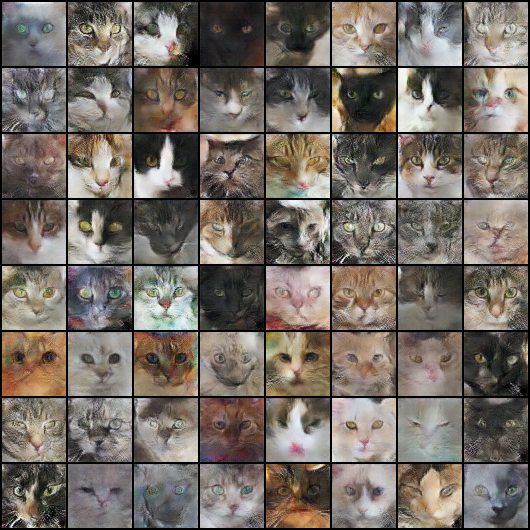

In [18]:
from IPython.display import Image
Image('./generated/0060.png')